In [65]:
import sys
sys.path.append('..')
from run_fft import FFTProcessor
import numpy as np
import pandas as pd
from collections import Counter

In [117]:
# Enable rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
fft_processor = FFTProcessor(method='fft', 
                             preprocess='logzs', 
                             value='norm', 
                             require_sid=False)

In [40]:
# Read NLL data, apply log z-score
# est_name = 'mistral'
est_name = 'gpt2xl'

nll_pubmed_orig = fft_processor._read_data(data_file=f'../data/gpt-4/pubmed_gpt-4.original.{est_name}.nll.txt')
nll_pubmed_samp = fft_processor._read_data(data_file=f'../data/gpt-4/pubmed_gpt-4.sampled.{est_name}.nll.txt')

# Log + Z-Score NLL
fft_processor.preprocess = 'logzs'
data = fft_processor._preprocess(nll_pubmed_orig)
df_nlllogzs_orig = fft_processor._create_input_df(data)
data = fft_processor._preprocess(nll_pubmed_samp)
df_nlllogzs_samp = fft_processor._create_input_df(data)
df_nlllogzs_orig['Source'] = 'Human'
df_nlllogzs_samp['Source'] = 'Model'
df_nlllogzs = pd.concat([df_nlllogzs_orig, df_nlllogzs_samp])

[1] 0.3137099
[1] 0.6148119
[1] 0.3946504
[1] 0.5146775
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.03984 -0.95584  0.03748  0.00000  0.83362  2.54442 


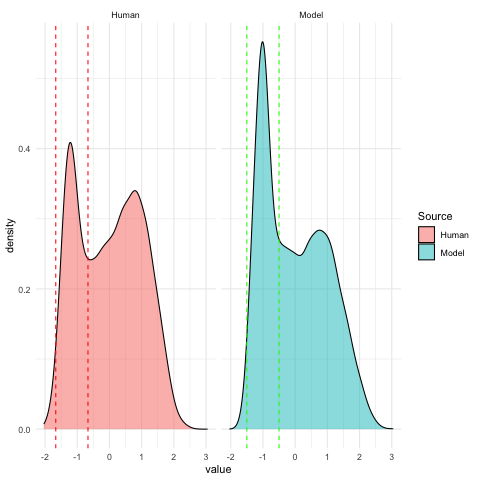

In [55]:
%%R -i df_nlllogzs
require("data.table")
require("ggplot2")

dt <- data.table(df_nlllogzs)
# nrow(dt)

# Density plot
# plot(density(dt[Source == "Human"]$value))

vline.dat <- data.table(Source=c("Human", "Human", "Model", "Model"), 
                        pos=c("left", "right", "left", "right"),
                        val=c(-1.667, -0.667, -1.5, -.5))
p <- ggplot(dt, aes(x=value, fill=Source)) + geom_density(alpha=0.5) + theme_minimal() + 
    facet_wrap(~Source) +
    geom_vline(vline.dat[Source=="Human" & pos=="left"], mapping=aes(xintercept=val), colour="red", linetype="dashed") + 
    geom_vline(vline.dat[Source=="Human" & pos=="right"], mapping=aes(xintercept=val), colour="red", linetype="dashed") + 
    geom_vline(vline.dat[Source=="Model" & pos=="left"], mapping=aes(xintercept=val), colour="green", linetype="dashed") + 
    geom_vline(vline.dat[Source=="Model" & pos=="right"], mapping=aes(xintercept=val), colour="green", linetype="dashed")
plot(p)

# Mistral results
# print(nrow(dt[Source == "Human" & value > -1.5 & value <= -0.5]) / nrow(dt[Source == "Human"])) # 0.4091184, left peak
# print(nrow(dt[Source == "Human" & value > -0.5 & value <= 2]) / nrow(dt[Source == "Human"])) # 0.5674812, right plateau

# GPT2-xl results
print(nrow(dt[Source == "Human" & value > -1.667 & value <= -0.667]) / nrow(dt[Source == "Human"])) #
print(nrow(dt[Source == "Human" & value > -0.667 & value <= 1.5]) / nrow(dt[Source == "Human"])) #
print(nrow(dt[Source == "Model" & value > -1.5 & value <= -0.5]) / nrow(dt[Source == "Model"])) #
print(nrow(dt[Source == "Model" & value > -0.5 & value <= 1.5]) / nrow(dt[Source == "Model"])) #


summary(dt[Source == "Human"]$value)

In [69]:
# Sanity check to see if tokenids.txt and nll.txt are aligned
tokenids_orig = fft_processor._read_data(data_file=f'../data/gpt-4/pubmed_gpt-4.original.gpt2_tokenids.txt')
tokenids_samp = fft_processor._read_data(data_file=f'../data/gpt-4/pubmed_gpt-4.sampled.gpt2_tokenids.txt')
# convert ids to int
tokenids_orig = [[int(x) for x in ids] for ids in tokenids_orig]
tokenids_samp = [[int(x) for x in ids] for ids in tokenids_samp]

for i in range(len(tokenids_orig)):
    assert len(tokenids_orig[i]) == len(nll_pubmed_orig[i]) + 1
for i in range(len(tokenids_samp)):
    assert len(tokenids_samp[i]) == len(nll_pubmed_samp[i]) + 1

In [70]:
# Get log z-score transformed NLL 
fft_processor.preprocess = 'logzs'
nlllogzs_orig = fft_processor._preprocess(nll_pubmed_orig)
nlllogzs_samp = fft_processor._preprocess(nll_pubmed_samp)
print(nll_pubmed_orig[0][:10])

[1.2931, 3.2406, 5.9268, 8.665, 7.573, 1.333, 6.0375, 4.6368, 1.2882, 6.3584]


In [72]:
left = -1.667
mid = -0.667
right = 1.5

# Vocabulary of human, in left peak and right plateau, respectively
vocab_human_left = Counter()
vocab_human_right = Counter()
for i in range(len(nlllogzs_orig)):
    token_ids = tokenids_orig[i]
    for j in range(len(nlllogzs_orig[i])):
        val = nlllogzs_orig[i][j]
        if val > left and val <= mid:
            vocab_human_left[token_ids[j+1]] += 1
        elif val > mid and val <= right:
            vocab_human_right[token_ids[j+1]] += 1

print(len(vocab_human_left))
print(len(vocab_human_right))

print('left top 10 tokens: ', vocab_human_left.most_common(10))
print('right top 10 tokens: ', vocab_human_right.most_common(10))

988
2121
left top 10 tokens:  [(286, 205), (25, 142), (13, 119), (30, 118), (284, 111), (262, 75), (11, 59), (351, 56), (287, 52), (12, 46)]
right top 10 tokens:  [(25, 183), (262, 177), (287, 176), (23998, 149), (290, 137), (257, 113), (13, 112), (11, 76), (318, 72), (286, 69)]


In [74]:
# Decode the token ids
from transformers import AutoTokenizer

gpt2_tokenizer = AutoTokenizer.from_pretrained('/Users/xy/models/gpt2-xl')

In [80]:
print('left top tokens: ')
for token_id, token_count in vocab_human_left.most_common(20):
    token = gpt2_tokenizer.decode(token_id)
    print(f'{token}', end=' ')

print('right top tokens: ')
for token_id, token_count in vocab_human_right.most_common(20):
    token = gpt2_tokenizer.decode(token_id)
    print(f'{token}', end=' ')

left top tokens: 
 of : . ?  to  the ,  with  in -  that  and  be  for  a  is al  patients  by ) right top tokens: 
:  the  in  Answer  and  a . ,  is  of  for  to -  The  patients  may  with  Does  Is  are 

### Qualitative exploration on `Answer:`

In [105]:
import re

text_samp = []
with open('../data/gpt-4/pubmed_gpt-4.sampled.txt', 'r') as f:
    for line in f:
        text_samp.append(line.strip())
model_yes_count, model_no_count = 0, 0
for text in text_samp:
    if re.search(r'Answer: Yes', text, re.IGNORECASE):
        model_yes_count += 1
    if re.search(r'Answer: No', text, re.IGNORECASE):
        model_no_count += 1
print('model yes count: ', model_yes_count)
print('model no count: ', model_no_count)

text_orig = []
with open('../data/gpt-4/pubmed_gpt-4.original.txt', 'r') as f:
    for line in f:
        text_orig.append(line.strip())
human_yes_count, human_no_count = 0, 0
for text in text_orig:
    if re.search(r'Answer: Yes', text, re.IGNORECASE):
        human_yes_count += 1
    if re.search(r'Answer: No', text, re.IGNORECASE):
        human_no_count += 1
print('human yes count: ', human_yes_count)
print('human no count: ', human_no_count)

# GPT-4, There are 78 out of 150 generated answers that start with "Yes, "
#   10 out of 150 start with "No, "
# 0 out of 150 human answers do

model yes count:  78
model no count:  10
human yes count:  0
human no count:  0


In [103]:
# gpt-3.5_turbo yes count

text_samp = []
with open('../data/gpt-3.5/pubmed_gpt-3.5-turbo.sampled.txt', 'r') as f:
    for line in f:
        text_samp.append(line.strip())
model_yes_count, model_no_count = 0, 0
for text in text_samp:
    if re.search(r'Answer: Yes', text, re.IGNORECASE):
        model_yes_count += 1
    if re.search(r'Answer: No', text, re.IGNORECASE):
        model_no_count += 1
print('model yes count: ', model_yes_count)
print('model no count: ', model_no_count)

text_orig = []
with open('../data/gpt-3.5/pubmed_gpt-3.5-turbo.original.txt', 'r') as f:
    for line in f:
        text_orig.append(line.strip())
human_yes_count, human_no_count = 0, 0
for text in text_orig:
    if re.search(r'Answer: Yes', text, re.IGNORECASE):
        human_yes_count += 1
    if re.search(r'Answer: No', text, re.IGNORECASE):
        human_no_count += 1
print('human yes count: ', human_yes_count)
print('human no count: ', human_no_count)

model yes count:  35
model no count:  2
human yes count:  0
human no count:  0


In [106]:
# davinci yes count

text_samp = []
with open('../data/davinci/pubmed_davinci.sampled.txt', 'r') as f:
    for line in f:
        text_samp.append(line.strip())
model_yes_count, model_no_count = 0, 0
for text in text_samp:
    if re.search(r'Answer: Yes', text, re.IGNORECASE):
        model_yes_count += 1
    if re.search(r'Answer: No', text, re.IGNORECASE):
        model_no_count += 1
print('model yes count: ', model_yes_count)
print('model no count: ', model_no_count)

text_orig = []
with open('../data/davinci/pubmed_davinci.original.txt', 'r') as f:
    for line in f:
        text_orig.append(line.strip())
human_yes_count, human_no_count = 0, 0
for text in text_orig:
    if re.search(r'Answer: Yes', text, re.IGNORECASE):
        human_yes_count += 1
    if re.search(r'Answer: No', text, re.IGNORECASE):
        human_no_count += 1
print('human yes count: ', human_yes_count)
print('human no count: ', human_no_count)

model yes count:  32
model no count:  32
human yes count:  0
human no count:  0


### Create text data without `Answer:`


In [110]:
text_samp
for text in text_samp:
    if re.search(r'Answer: Yes', text, re.IGNORECASE):
        print(text)
        break

new_text = re.sub(r'(?<=Answer: )Yes[,|.]*', '', text)
print(new_text)

Question: Is coeliac disease screening in risk groups justified? Answer: Yes. Read on for details and an offer of a free book!
Question: Is coeliac disease screening in risk groups justified? Answer:  Read on for details and an offer of a free book!


In [115]:
# samp_file = '../data/gpt-4/pubmed_gpt-4.sampled.txt'
# new_samp_file = '../data/gpt-4/pubmed_gpt-4.sampled.rmyesno.txt'

# samp_file = '../data/gpt-3.5/pubmed_gpt-3.5-turbo.sampled.txt'
# new_samp_file = '../data/gpt-3.5/pubmed_gpt-3.5-turbo.sampled.rmyesno.txt'

samp_file = '../data/davinci/pubmed_davinci.sampled.txt'
new_samp_file = '../data/davinci/pubmed_davinci.sampled.rmyesno.txt'

with open(samp_file, 'r') as f, open(new_samp_file, 'w') as f2:
    for line in f:
        if re.search(r'Answer: Yes', line, re.IGNORECASE):
            new_line = re.sub(r'(?<=Answer: )Yes[,|.]*', '', line)
        elif re.search(r'Answer: No', line, re.IGNORECASE):
            new_line = re.sub(r'(?<=Answer: )No[,|.]*', '', line)
        else:
            new_line = line
        f2.write(new_line)

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


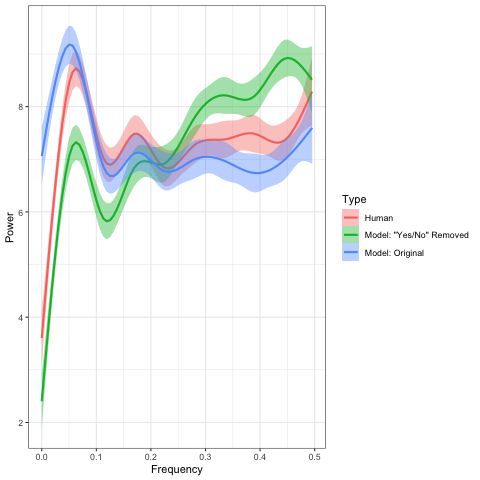

In [132]:
%%R 
# Plot spectrum before and after removing "Yes, " and "No, "
require("data.table")
require("ggplot2")

samp_gpt4 <- fread("../data/gpt-4/pubmed_gpt-4.sampled.gpt2xl.nllzs.fftnorm.txt")
samprm_gpt4 <- fread("../data/gpt-4/pubmed_gpt-4.sampled.rmyesno.gpt2xl.nllzs.fftnorm.txt")
samp_gpt4$Type <- "Model: Original"
samprm_gpt4$Type <- "Model: \"Yes/No\" Removed"

orig_gpt4 <- fread("../data/gpt-4/pubmed_gpt-4.original.gpt2xl.nllzs.fftnorm.txt")
orig_gpt4$Type <- "Human"

d_gpt4 <- rbind(samp_gpt4, samprm_gpt4, orig_gpt4)
p <- ggplot(d_gpt4, aes(x=freq, y=power)) + 
    geom_smooth(aes(fill=Type, colour=Type)) + theme_bw() +
    xlab("Frequency") + ylab("Power")
p
